In [3]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import os

In [11]:
df = pd.read_csv('../data/multitask_processed.csv', low_memory=False)
df = df.replace([np.inf, -np.inf], np.nan)

In [12]:
X_all = df.drop(
    columns=[c for c in df.columns if c.startswith("ic50_") or c.startswith("pIC50_")]
).select_dtypes(include=[np.number])

In [6]:
os.makedirs('../models', exist_ok=True)

In [13]:
results = []
for target in ['bace1', 'gsk3b', 'ache']:
    y_col = f'pIC50_{target}'
    mask = df[y_col].notna()
    n_points = mask.sum()
    print(f"\nTarget {target}: {n_points} points")
    if n_points < 100:
        print(f"Пропускаем {target}: слишком мало данных (<100).")
        continue

    X = X_all.loc[mask]
    y = df.loc[mask, y_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(
        n_estimators=200, max_depth=10, random_state=42, n_jobs=-1
    )
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{target}: R2 = {r2:.3f}, RMSE = {rmse:.3f}")

    model_path = f"../models/rf_{target}.joblib"
    joblib.dump(model, model_path)
    print("Saved model to", model_path)

    results.append({
        'target': target,
        'n_points': n_points,
        'r2': r2,
        'rmse': rmse
    })


Target bace1: 7459 points


bace1: R2 = 0.633, RMSE = 0.860
Saved model to ../models/rf_bace1.joblib

Target gsk3b: 1857 points
gsk3b: R2 = 0.561, RMSE = 0.878
Saved model to ../models/rf_gsk3b.joblib

Target ache: 250 points
ache: R2 = 0.639, RMSE = 0.915
Saved model to ../models/rf_ache.joblib


In [14]:
results_df = pd.DataFrame(results)
display(results_df)

,target,n_points,r2,rmse
0,bace1,7459,0.632899,0.859646
1,gsk3b,1857,0.560606,0.878390
2,ache,250,0.639250,0.914783


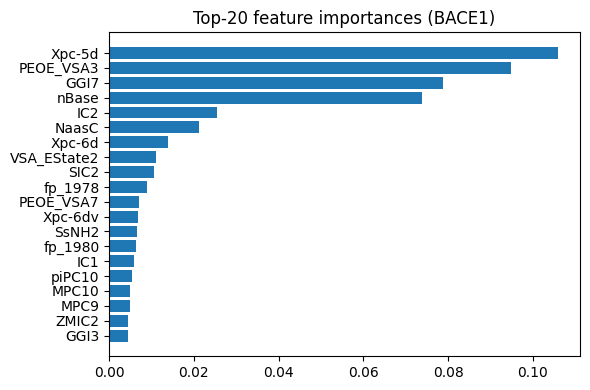

In [15]:
if 'bace1' in results_df.target.values:
    rf_bace1 = joblib.load('../models/rf_bace1.joblib')
    importances = rf_bace1.feature_importances_
    idx = np.argsort(importances)[-20:]  # топ-20
    plt.figure(figsize=(6,4))
    plt.barh(range(len(idx)), importances[idx])
    plt.yticks(range(len(idx)), [X_all.columns[i] for i in idx])
    plt.title('Top-20 feature importances (BACE1)')
    plt.tight_layout()
    plt.show()